In [ ]:
%matplotlib inline
%run ../../setup/nb_setup

# Orbits 2: Orbits in Axisymmetric Potentials

## Solutions to Exercises

In [1]:
from astropy.constants import G
import astropy.units as u

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

In [2]:
mn_disk = gp.MiyamotoNagaiPotential(
    m=6.98e10 * u.Msun, a=3 * u.kpc, b=0.28 * u.kpc, units=galactic
)

### Exercise: Defining an comparison Plummer model

As mentioned above, in a particular limit, the MN potential becomes the Plummer potential. What should we set the Plummer scale length to so that, in the midplane (z=0) it has the same profile as our MN potential? I.e. what combination of the MN scale parameters $a_\textrm{MN}$ and $b_\textrm{MN}$ should we set the Plummer scale length to?

Write the answer here:

Define the comparison Plummer model using the mass from the MN potential, and the correct combination of the MN scale parameters (you can use `mn_disk.parameters['m']`, `mn_disk.parameters['a']`, and `mn_disk.parameters['b']` to retrieve the parameter values so you don't have to re-define them).

*Solution*: 

A Plummer model that is equivalent to the MN potential at its midplane (z=0) will have a Plummer scale length that is equal to the sum of the MN parameters:

$$
b_\textrm{Plummer} = a_\textrm{MN} + b_\textrm{MN}
$$

In [3]:
plummer = gp.PlummerPotential(
    m=mn_disk.parameters["m"],
    b=mn_disk.parameters["a"] + mn_disk.parameters["b"],
    units=galactic,
)

xyz = [8, 0, 0] * u.kpc
Menc_MN = mn_disk.mass_enclosed(xyz)
Menc_plummer = plummer.mass_enclosed(xyz)
print(Menc_MN, Menc_plummer)

[5.52885737e+10] solMass [5.52885737e+10] solMass


### Exercise: Why do the orbits in the Miyamoto–Nagai potential look different from the Plummer orbits?

Compute and plot the three components of the angular momentum for all orbits in both potentials. Do you see any differences? Given what we discussed about integrals of motion in the last tutorial, what do you think the connection is between the angular momentum components and the phase-space properties of the orbit?

*Solution*: 

In [4]:
mn_dt = 1.0 * u.Myr
mn_steps = 4000

mn_xyz = ([[8, 0, 0.0], [8, 0, 1.0], [8, 0, 10.0]] * u.kpc).T
mn_vcirc = mn_disk.circular_velocity(mn_xyz)
mn_vxyz = mn_vcirc[np.newaxis] * np.array([0.1, 1, 0])[:, np.newaxis]
mn_w0 = gd.PhaseSpacePosition(pos=mn_xyz, vel=mn_vxyz)

mn_orbits = mn_disk.integrate_orbit(mn_w0, dt=mn_dt, n_steps=mn_steps)
plummer_orbits = plummer.integrate_orbit(mn_w0, dt=mn_dt, n_steps=mn_steps)

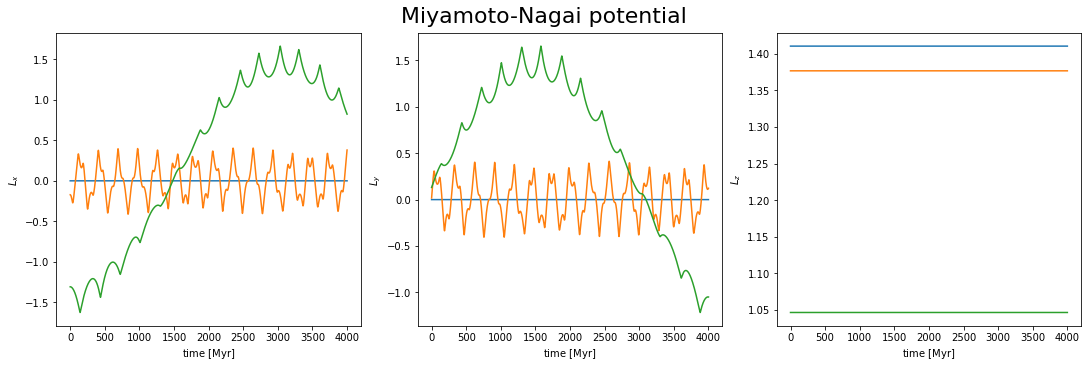

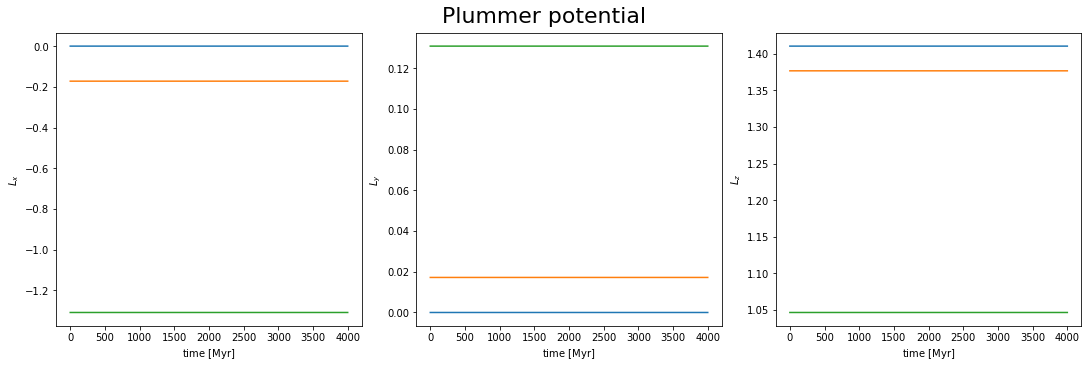

In [5]:
for orbits, name in zip([mn_orbits, plummer_orbits], ["Miyamoto-Nagai", "Plummer"]):
    L = orbits.angular_momentum()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
    for i, (ax, lbl) in enumerate(zip(axes, ["$L_x$", "$L_y$", "$L_z$"])):
        ax.plot(orbits.t, L[i])
        ax.set_ylabel(lbl)
        ax.set_xlabel(f"time [{orbits.t.unit:latex_inline}]")
    fig.suptitle(f"{name} potential", fontsize=22)

Comparing these two potentials: In the Miyamoto–Nagai potential, generic orbits out of symmetry plane do not conserve the $x$ or $y$ components of the angular momentum, but the $z$ component of the angular momentum is still conserved. Of the integrals of motion we have discussed so far, orbits in axisymmetric potentials therefore only conserve energy $E$ and the $z$-component of the angular momentum $L_z$. However, if we integrate these orbits for a long time, we would find that they fill a 3D subspace of the full 6D phase-space. This implies that there must be a third isolating integral of motion that reduces the dimensionality of the orbit. In the context of "classical" integrals of motion (like $E$ and $L_z$), this third integral of motion is often called...*the third integral*. There is no general closed-form expression for the third integral as a function of the phase-space coordinates.

### Exercise: Estimate the guiding center radius for an orbit in the Miyamoto–Nagai potential

Estimate the guiding center radius of a planar orbit in the MN potential (the `mn_disk` we defined above) with the initial conditions:

$$
(x,y,z) = (8.5, 0, 0.02)~\textrm{kpc}\\
(v_x,v_y,v_z) = (0, 168, 0)~\textrm{km}~\textrm{s}^{-1}\\
$$

Hint: you might find the root finder `scipy.optimize.root` useful!

Compute an orbit from these initial conditions, plot it in the meridional plane, and draw a vertical line on the plot at the location of the guiding center radius.

*Solution:*

In [ ]:
from scipy.optimize import root

In [ ]:
w0 = gd.PhaseSpacePosition(pos=[8.5, 0, 0.02] * u.kpc, vel=[0, 168, 0] * u.km / u.s)

In [ ]:
trial_L = w0.angular_momentum()
trial_Lz = trial_L[2]

In [ ]:
def root_func(Rg, pot, Lz):
    dPhi_dR = pot.gradient([Rg[0], 0, 0]).to_value(Lz.unit ** 2 / u.kpc ** 3)[0, 0]
    return dPhi_dR - Lz.value ** 2 / Rg[0] ** 3

In [ ]:
result = root(root_func, [8.0], args=(mn_disk, trial_Lz))
trial_Rg = result.x[0] * u.kpc
print(f"Guiding center radius: {trial_Rg.value:.2f} kpc")

In [ ]:
trial_orbit = mn_disk.integrate_orbit(
    w0, dt=0.1 * u.Myr, t1=0, t2=2 * u.Gyr, Integrator=gi.DOPRI853Integrator
)

In [ ]:
fig = trial_orbit.cylindrical.plot(["rho", "z"], labels=["$R$", "$z$"])
fig.axes[0].axvline(trial_Rg.value, color="tab:red")

### Exercise: Estimate (analytically) the radial, vertical, and azimuthal frequencies for an orbit at the Solar radius

The Sun is approximately at a radius of $R_\odot \approx 8.1~\textrm{kpc}$ in the Milky Way's disk. This region of the disk is still dominated (in mass) by the gravitational potential of the stars and gas, so we can neglect the dark matter halo for first approximation. 

Assuming $R_g = R_\odot$, estimate the azimuthal frequency of a circular orbit at the Solar circle using the `mn_disk` potential we defined above.

*Solution:*

In [ ]:
sun_Rg = 8.1 * u.kpc
sun_vcirc = mn_disk.circular_velocity([1, 0, 0] * sun_Rg)
sun_Lz = sun_Rg * sun_vcirc[0]

In [ ]:
sun_Omega_phi = sun_Lz / sun_Rg ** 2
sun_Omega_phi = sun_Omega_phi.to(u.rad / u.Gyr, u.dimensionless_angles())
sun_Omega_phi

Recall that the expression for the effective potential for a Miyamoto–Nagai disk is:

$$
\Phi_\textrm{eff}(R, z) = - \frac{G \, M}{\sqrt{R^2 + (a + \sqrt{b^2 + z^2})^2}} + \frac{L_z^2}{2\,R^2}
$$

Estimate the radial and vertical frequencies for an orbit near the solar circle. How do the frequency and period values compare (radial to azimuthal to vertical)?

*Hint: you either want to take second derivatives of the expression above and evaluate this manually, or you can use the `.hessian()` method on any Gala potential object (but note that this computes the Cartesian 2nd derivative matrix at a specified position)*

*Solution:*

One way to solve for the other frequencies is to take the derivatives of the effective potential expression above using Wolfram Alpha, or Mathematica, or Sympy, and evaluate them at $(R, z) = (R_g, 0)$:

In [ ]:
import sympy as sy

_G, _M, _R, _z, _a, _b, _Lz, _Rg = sy.symbols(
    "G, M, R, z, a, b, L_z, R_g", real=True, positive=True
)

MN_Phi_eff = -_G * _M / sy.sqrt(
    _R ** 2 + (_a + sy.sqrt(_z ** 2 + _b ** 2)) ** 2
) + _Lz ** 2 / (2 * _R ** 2)

In [ ]:
sy.simplify(sy.diff(MN_Phi_eff, _R, 2).subs({_R: _Rg, _z: 0}))

In [ ]:
sy.simplify(sy.diff(MN_Phi_eff, _z, 2).subs({_R: _Rg, _z: 0}))

However, Gala Potential objects can also compute the matrix of 2nd derivatives (the Hessian) using the `.hessian()` method. If we evaluate this at a position along the $x$ axis, the $\partial^2/\partial^2 x$ term is equivalent to the $\partial^2/\partial^2 R$ term (but we have to remember to add the term to make it the derivative of the *effective* potential):

In [ ]:
mn_Hess = mn_disk.hessian([1, 0, 0] * sun_Rg)[..., 0]
mn_d2Phi_dR2 = mn_Hess[0, 0]
mn_d2Phi_dz2 = mn_Hess[2, 2]

mn_d2Phi_eff_dR2 = mn_d2Phi_dR2 + 3 * sun_Lz ** 2 / sun_Rg ** 4

In [ ]:
sun_Omega_R = np.sqrt(mn_d2Phi_eff_dR2).to(u.rad / u.Gyr, u.dimensionless_angles())
sun_Omega_z = np.sqrt(mn_d2Phi_dz2).to(u.rad / u.Gyr, u.dimensionless_angles())

In [ ]:
print(f"Radial frequency: {sun_Omega_R:.1f}")
print(f"Azimuthal frequency: {sun_Omega_phi:.1f}")
print(f"Vertical frequency: {sun_Omega_z:.1f}")

In [ ]:
print(f"Radial period: {(2*np.pi*u.rad / sun_Omega_R).to(u.Myr):.1f}")
print(f"Azimuthal period: {(2*np.pi*u.rad / sun_Omega_phi).to(u.Myr):.1f}")
print(f"Vertical period: {(2*np.pi*u.rad / sun_Omega_z).to(u.Myr):.1f}")

These values are approximate and neglect the mass from the dark matter, but the ranking is typical for a typical star in the Galactic disk: The vertical frequency is much faster than the radial and azimuthal frequencies, which can have comparable values. 

### Exercise: Are there values for the parameters (q, r_c) that lead to unphysical density values?

*Solution:*

Yes! Consider positions along $R=0$: The density is proportional to

$$
\begin{align}
\rho_L(0, z) &\propto (2\,q^2 + 1)r_c^2 + (2 - \frac{1}{q^2})\,z^2\\
    &\propto (2\,q^2 + 1)r_c^2 + 2\,z^2 - \frac{1}{q^2}\,z^2
\end{align}
$$

so, when

$$
\frac{1}{q^2}\,z^2 > (2\,q^2 + 1)r_c^2 + 2\,z^2
$$

the mass density will be negative! Assuming $r_c = 1$,

In [ ]:
z = np.linspace(0, 10, 256)
for q in np.linspace(0.5, 1, 8):
    plt.plot(
        z,
        2 * q ** 2 + 1 + 2 * z ** 2 - z ** 2 / q ** 2,
        marker="",
        label=f"$q={q:.2f}$",
    )
plt.axhline(0, color="#aaaaaa")
plt.ylim(-10, 10)
plt.legend()
plt.xlabel("$z$")
plt.ylabel(r"$2\,q^2 + 1 + 2\,z^2 - \frac{z^2}{q^2}$")